In [1]:
import cv2
import keras
from keras.applications.imagenet_utils import preprocess_input
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D,Lambda
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from random import shuffle
from scipy.misc import imread
from scipy.misc import imresize
import tensorflow as tf
%matplotlib inline

Using TensorFlow backend.


In [2]:
#dataset
import hickle as hkl
import numpy as np
from keras.preprocessing.image import Iterator

In [3]:
import os
def _load_image_set_idx(_data_root_path,_image_set):
    image_set_file = os.path.join(
        _data_root_path, 'ImageSets', _image_set+'.txt')
    assert os.path.exists(image_set_file), \
        'File does not exist: {}'.format(image_set_file)

    with open(image_set_file) as f:
      image_idx = [x.strip() for x in f.readlines()]
    return image_idx

In [4]:
idx_train = _load_image_set_idx('KITTI','train')
print(len(idx_train))

3740


In [5]:
idx_trainval = _load_image_set_idx('KITTI','trainval')
print(len(idx_trainval))

7481


In [6]:
idx_val = _load_image_set_idx('KITTI','val')
print(len(idx_val))

3741


In [7]:
def _get_idx_path(idx, img_path):
    image_path = os.path.join(img_path, idx+'.png')
    assert os.path.exists(image_path), \
        'Image does not exist: {}'.format(image_path)
    return image_path

In [8]:
print(_get_idx_path(idx_train[0], './KITTI/training/image_2/'))

./KITTI/training/image_2/000000.png


In [9]:
def _read_annotation(idx, annotation_path):
    def _get_obj_level(obj):
      height = float(obj[7]) - float(obj[5]) + 1
      trucation = float(obj[1])
      occlusion = float(obj[2])
      if height >= 40 and trucation <= 0.15 and occlusion <= 0:
          return 1
      elif height >= 25 and trucation <= 0.3 and occlusion <= 1:
          return 2
      elif height >= 25 and trucation <= 0.5 and occlusion <= 2:
          return 3
      else:
          return 4
    idx2annotation = {}
    for index in idx:
      filename = os.path.join(annotation_path, index+'.txt')
      with open(filename, 'r') as f:
        lines = f.readlines()
      f.close()
      bboxes = []
      for line in lines:
        obj = line.strip().split(' ')
        cls = obj[0].lower().strip()
        if _get_obj_level(obj) > 3:
          continue
        xmin = float(obj[4])
        ymin = float(obj[5])
        xmax = float(obj[6])
        ymax = float(obj[7])
        assert xmin >= 0.0 and xmin <= xmax, \
            'Invalid bounding box x-coord xmin {} or xmax {} at {}.txt' \
                .format(xmin, xmax, index)
        assert ymin >= 0.0 and ymin <= ymax, \
            'Invalid bounding box y-coord ymin {} or ymax {} at {}.txt' \
                .format(ymin, ymax, index)
        #x, y, w, h = bbox_transform_inv([xmin, ymin, xmax, ymax])
        #bboxes.append([x, y, w, h, cls])
        bboxes.append([xmin, ymin, xmax, ymax, cls])
      idx2annotation[index] = bboxes

    return idx2annotation

In [10]:
#saving to csv
df = _read_annotation(idx_train, './KITTI/training/label_2/')
print(len(df))

3740


In [11]:
#name = {'index':[],'cls':[],'x1':[],'y1':[],'x2':[],'y2':[]}
data = pd.DataFrame(columns=['index','cls','x1','y1','x2','y2'])
#data = pd.DataFrame({'idx':[],'cls':[],'x1':[],'y1':[],'x2':[],'y2':[]})
lists = []
for d in df:
    for i in range(len(df[d])):
        #print(df[d][0][0])
        #lists.append([d,df[i][0][4],df[i][0][0],df[i]])
        data2 = {'index':d,'cls':df[d][i][4],'x1':df[d][i][0],'y1':df[d][i][1],'x2':df[d][i][2],'y2':df[d][i][3]}
        data = data.append(data2, ignore_index=True)
    #print(len(df[d]))
data.head()

,index,cls,x1,y1,x2,y2
0,000815,car,578.04,175.81,635.29,231.28
1,000564,car,247.81,194.06,501.75,370.17
2,000564,car,545.17,180.12,608.18,224.86
3,000564,pedestrian,875.82,164.86,891.82,210.19
4,000447,car,0.76,180.27,119.11,219.40


In [12]:
data.to_csv('kitti.csv')

In [13]:
#Load Udacity's DataSet
#code as below are copy from Udacity's Self Driving Car Open Source Project
#I want use U-net as Region Proposal Nets, and then using with ROI Pool layer as full detection nets
#later, add kitti dataset 

In [14]:
datapath = ['object-detection-crowdai']
dataset = ['labels_crowdai.csv']
df_files1 = pd.read_csv(dataset[0], header=0)
df_vehicles1 = df_files1[(df_files1['Label']=='Car') | (df_files1['Label']=='Truck')].reset_index()
df_vehicles1 = df_vehicles1.drop('index', 1)
df_vehicles1['File_Path'] =  datapath[0] + '/' +df_vehicles1['Frame']
df_vehicles1 = df_vehicles1.drop('Preview URL', 1)
print(dataset[0])
df_vehicles1.head()

labels_crowdai.csv


,xmin,ymin,xmax,ymax,Frame,Label,File_Path
0,785,533,905,644,1479498371963069978.jpg,Car,object-detection-crowdai/1479498371963069978.jpg
1,89,551,291,680,1479498371963069978.jpg,Car,object-detection-crowdai/1479498371963069978.jpg
2,268,546,383,650,1479498371963069978.jpg,Car,object-detection-crowdai/1479498371963069978.jpg
3,455,522,548,615,1479498371963069978.jpg,Truck,object-detection-crowdai/1479498371963069978.jpg
4,548,522,625,605,1479498371963069978.jpg,Truck,object-detection-crowdai/1479498371963069978.jpg


In [15]:
trans_range = 0

In [16]:
#data augmentation

In [17]:
def augment_brightness_camera_images(image):
    
    ### Augment brightness 
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    #print(random_bright)
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def trans_image(image,bb_boxes_f,trans_range):
    # Translation augmentation
    bb_boxes_f = bb_boxes_f.copy(deep=True)

    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2

    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    rows,cols,channels = image.shape
    bb_boxes_f['xmin'] = bb_boxes_f['xmin']+tr_x
    bb_boxes_f['xmax'] = bb_boxes_f['xmax']+tr_x
    bb_boxes_f['ymin'] = bb_boxes_f['ymin']+tr_y
    bb_boxes_f['ymax'] = bb_boxes_f['ymax']+tr_y
    
    image_tr = cv2.warpAffine(image,Trans_M,(cols,rows))
    
    return image_tr,bb_boxes_f


def stretch_image(img,bb_boxes_f,scale_range):
    # Stretching augmentation 
    
    bb_boxes_f = bb_boxes_f.copy(deep=True)
    
    tr_x1 = scale_range*np.random.uniform()
    tr_y1 = scale_range*np.random.uniform()
    p1 = (tr_x1,tr_y1)
    tr_x2 = scale_range*np.random.uniform()
    tr_y2 = scale_range*np.random.uniform()
    p2 = (img.shape[1]-tr_x2,tr_y1)

    p3 = (img.shape[1]-tr_x2,img.shape[0]-tr_y2)
    p4 = (tr_x1,img.shape[0]-tr_y2)

    pts1 = np.float32([[p1[0],p1[1]],
                   [p2[0],p2[1]],
                   [p3[0],p3[1]],
                   [p4[0],p4[1]]])
    pts2 = np.float32([[0,0],
                   [img.shape[1],0],
                   [img.shape[1],img.shape[0]],
                   [0,img.shape[0]] ]
                   )

    M = cv2.getPerspectiveTransform(pts1,pts2)
    img = cv2.warpPerspective(img,M,(img.shape[1],img.shape[0]))
    img = np.array(img,dtype=np.uint8)
    
    bb_boxes_f['xmin'] = (bb_boxes_f['xmin'] - p1[0])/(p2[0]-p1[0])*img.shape[1]
    bb_boxes_f['xmax'] = (bb_boxes_f['xmax'] - p1[0])/(p2[0]-p1[0])*img.shape[1]
    bb_boxes_f['ymin'] = (bb_boxes_f['ymin'] - p1[1])/(p3[1]-p1[1])*img.shape[0]
    bb_boxes_f['ymax'] = (bb_boxes_f['ymax'] - p1[1])/(p3[1]-p1[1])*img.shape[0]
    
    return img,bb_boxes_f



def get_image_name(df,ind,size=(640,300),augmentation = False,trans_range = 20,scale_range=20):
    ### Get image by name
    
    file_name = df['File_Path'][ind]
    #print(file_name)
    img = cv2.imread(file_name)
    img_size = np.shape(img)
    
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,size)
    name_str = file_name.split('/')
    name_str = name_str[-1]
    #print(name_str)
    #print(file_name)
    bb_boxes = df[df['Frame'] == name_str].reset_index()
    img_size_post = np.shape(img)
    
    if augmentation == True:
        img,bb_boxes = trans_image(img,bb_boxes,trans_range)
        img,bb_boxes = stretch_image(img,bb_boxes,scale_range)
        img = augment_brightness_camera_images(img)
        
    bb_boxes['xmin'] = np.round(bb_boxes['xmin']/img_size[1]*img_size_post[1])
    bb_boxes['xmax'] = np.round(bb_boxes['xmax']/img_size[1]*img_size_post[1])
    bb_boxes['ymin'] = np.round(bb_boxes['ymin']/img_size[0]*img_size_post[0])
    bb_boxes['ymax'] = np.round(bb_boxes['ymax']/img_size[0]*img_size_post[0])
    bb_boxes['Area'] = (bb_boxes['xmax']- bb_boxes['xmin'])*(bb_boxes['ymax']- bb_boxes['ymin']) 
    #bb_boxes = bb_boxes[bb_boxes['Area']>400]
        
    
    return name_str,img,bb_boxes


def get_mask_seg(img,bb_boxes_f):
    
    #### Get mask 
    
    img_mask = np.zeros_like(img[:,:,0])
    for i in range(len(bb_boxes_f)):
        #plot_bbox(bb_boxes,i,'g')
        bb_box_i = [bb_boxes_f.iloc[i]['xmin'],bb_boxes_f.iloc[i]['ymin'],
                bb_boxes_f.iloc[i]['xmax'],bb_boxes_f.iloc[i]['ymax']]
        #print(bb_box_i)
        img_mask[int(bb_box_i[1]):int(bb_box_i[3]),int(bb_box_i[0]):int(bb_box_i[2])]= 1.
        img_mask = np.reshape(img_mask,(np.shape(img_mask)[0],np.shape(img_mask)[1],1))
    return img_mask

In [18]:
def plot_im_mask(im,im_mask):
    ### Function to plot image mask 
    
    im = np.array(im,dtype=np.uint8)
    im_mask = np.array(im_mask,dtype=np.uint8)
    plt.subplot(1,3,1)
    plt.imshow(im)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(im_mask[:,:,0])
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(cv2.bitwise_and(im,im,mask=im_mask));
    plt.axis('off')
    plt.show();
    
def plot_bbox(bb_boxes,ind_bb,color='r',linewidth=2):
    ### Plot bounding box
    
    bb_box_i = [bb_boxes.iloc[ind_bb]['xmin'],
                bb_boxes.iloc[ind_bb]['ymin'],
                bb_boxes.iloc[ind_bb]['xmax'],
                bb_boxes.iloc[ind_bb]['ymax']]
    plt.plot([bb_box_i[0],bb_box_i[2],bb_box_i[2],
                  bb_box_i[0],bb_box_i[0]],
             [bb_box_i[1],bb_box_i[1],bb_box_i[3],
                  bb_box_i[3],bb_box_i[1]],
             color,linewidth=linewidth)
    
def plot_im_bbox(im,bb_boxes):
    ### Plot image and bounding box
    plt.imshow(im)
    for i in range(len(bb_boxes)):
        plot_bbox(bb_boxes,i,'g')
    
        bb_box_i = [bb_boxes.iloc[i]['xmin'],bb_boxes.iloc[i]['ymin'],
                bb_boxes.iloc[i]['xmax'],bb_boxes.iloc[i]['ymax']]
        plt.plot(bb_box_i[0],bb_box_i[1],'rs')
        plt.plot(bb_box_i[2],bb_box_i[3],'bs')
    plt.axis('off');

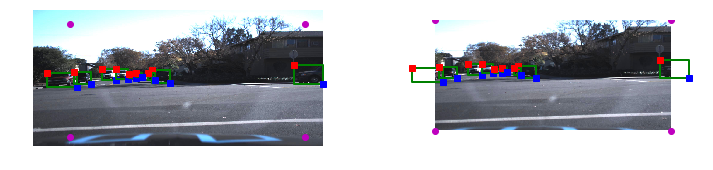

In [19]:
df_vehicles = df_vehicles1
name_str,img,bb_boxes = get_image_name(df_vehicles,1,augmentation=False,trans_range=0,scale_range=0)
img_mask =get_mask_seg(img,bb_boxes)

tr_x1 = 80
tr_y1 = 30
tr_x2 = 40
tr_y2 = 20

p1 = (tr_x1,tr_y1)
p2 = (img.shape[1]-tr_x2,tr_y1)

p3 = (img.shape[1]-tr_x2,img.shape[0]-tr_y2)
p4 = (tr_x1,img.shape[0]-tr_y2)

pts1 = np.float32([[p1[0],p1[1]],
                   [p2[0],p2[1]],
                   [p3[0],p3[1]],
                   [p4[0],p4[1]]])
pts2 = np.float32([[0,0],
                   [img.shape[1],0],
                   [img.shape[1],img.shape[0]],[0,img.shape[0]] ]
                   )

M = cv2.getPerspectiveTransform(pts1,pts2)
dst = cv2.warpPerspective(img,M,(img.shape[1],img.shape[0]))
dst = np.array(dst,dtype=np.uint8)


plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(img)
plt.plot(p1[0],p1[1],'mo')
plt.plot(p2[0],p2[1],'mo')
plt.plot(p3[0],p3[1],'mo')
plt.plot(p4[0],p4[1],'mo')
for i in range(len(bb_boxes)):
    plot_bbox(bb_boxes,i,'g')
    
    bb_box_i = [bb_boxes.iloc[i]['xmin'],bb_boxes.iloc[i]['ymin'],
                bb_boxes.iloc[i]['xmax'],bb_boxes.iloc[i]['ymax']]
    plt.plot(bb_box_i[0],bb_box_i[1],'rs')
    plt.plot(bb_box_i[2],bb_box_i[3],'bs')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(dst)
bb_boxes1 = bb_boxes.copy(deep=True)
bb_boxes1['xmin'] = (bb_boxes['xmin'] - p1[0])/(p2[0]-p1[0])*img.shape[1]
bb_boxes1['xmax'] = (bb_boxes['xmax'] - p1[0])/(p2[0]-p1[0])*img.shape[1]
bb_boxes1['ymin'] = (bb_boxes['ymin'] - p1[1])/(p3[1]-p1[1])*img.shape[0]
bb_boxes1['ymax'] = (bb_boxes['ymax'] - p1[1])/(p3[1]-p1[1])*img.shape[0]
plt.plot(0,0,'mo')
plt.plot(img.shape[1],0,'mo')
plt.plot(img.shape[1],img.shape[0],'mo')
plt.plot(0,img.shape[0],'mo')
plot_im_bbox(dst,bb_boxes1)

plt.axis('off');

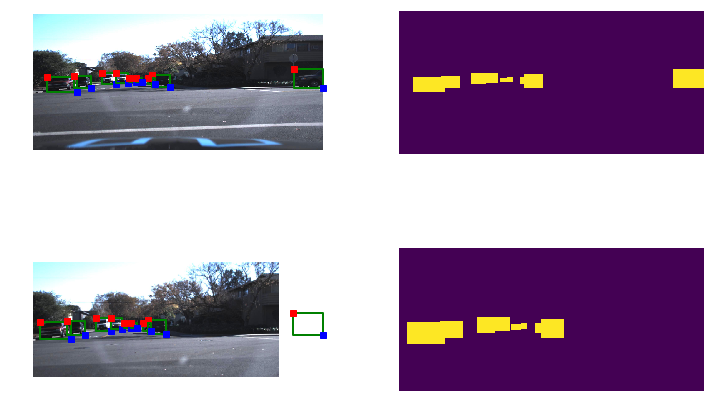

In [20]:
name_str,img,bb_boxes = get_image_name(df_vehicles,1,augmentation=False)
img_mask =get_mask_seg(img,bb_boxes)

plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plot_im_bbox(img,bb_boxes)

plt.subplot(2,2,2)
plt.imshow(img_mask[:,:,0])
plt.axis('off')

plt.subplot(2,2,3)
#bb_boxes1 = bb_boxes.copy()
dst,bb_boxes1 = stretch_image(img,bb_boxes,100)

plt.imshow(dst)

plot_im_bbox(dst,bb_boxes1)

plt.subplot(2,2,4)
img_mask2 =get_mask_seg(dst,bb_boxes1)
plt.imshow(img_mask2[:,:,0])
plt.axis('off');

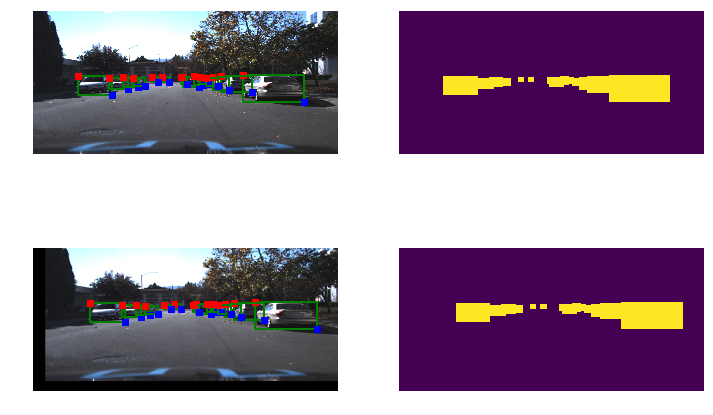

In [21]:
name_str,img,bb_boxes = get_image_name(df_vehicles,200,augmentation=False)
img_mask =get_mask_seg(img,bb_boxes)

plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plot_im_bbox(img,bb_boxes)

plt.subplot(2,2,2)
plt.imshow(img_mask[:,:,0])
plt.axis('off')

plt.subplot(2,2,3)
#bb_boxes1 = bb_boxes.copy()
img_trans,bb_boxes1 = trans_image(img,bb_boxes,100)

plt.imshow(img_trans)

plot_im_bbox(img_trans,bb_boxes1)
img_mask2 =get_mask_seg(img_trans,bb_boxes1)

plt.subplot(2,2,4)
plt.imshow(img_mask2[:,:,0])
plt.axis('off');

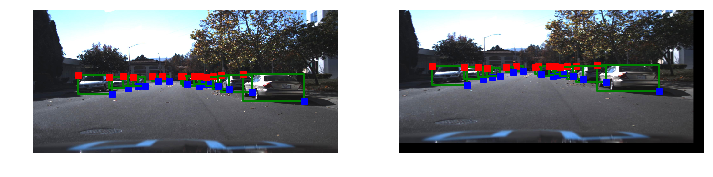

In [22]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plot_im_bbox(img,bb_boxes)
plt.subplot(2,2,2)
#bb_boxes1 = bb_boxes.copy()
img_trans,bb_boxes1 = trans_image(img,bb_boxes,50)
plt.imshow(img_trans)
plot_im_bbox(img_trans,bb_boxes1)

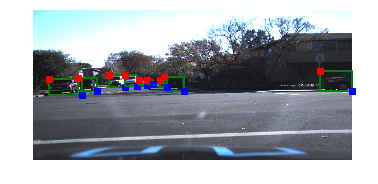

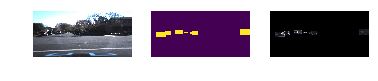

In [23]:
name_str,img,bb_boxes = get_image_name(df_vehicles,1,augmentation=False)
img_mask =get_mask_seg(img,bb_boxes)


plt.figure(figsize=(6,4))
plt.imshow(img)
plot_im_bbox(img,bb_boxes)
plt.show()

plot_im_mask(img,img_mask)

In [24]:
#### Training generator, generates augmented images
def generate_train_batch(data,batch_size = 32):
    
    batch_images = np.zeros((batch_size, img_rows, img_cols, 3))
    batch_masks = np.zeros((batch_size, img_rows, img_cols, 1))
    while 1:
        for i_batch in range(batch_size):
            i_line = np.random.randint(len(data)-2000)
            name_str,img,bb_boxes = get_image_name(df_vehicles,i_line,
                                                   size=(img_cols, img_rows),
                                                  augmentation=True,
                                                   trans_range=50,
                                                   scale_range=50
                                                  )
            img_mask = get_mask_seg(img,bb_boxes)
            batch_images[i_batch] = img
            batch_masks[i_batch] =img_mask
        yield batch_images, batch_masks
        
#### Testing generator, generates augmented images
def generate_test_batch(data,batch_size = 32):
    batch_images = np.zeros((batch_size, img_rows, img_cols, 3))
    batch_masks = np.zeros((batch_size, img_rows, img_cols, 1))
    while 1:
        for i_batch in range(batch_size):
            i_line = np.random.randint(2000)
            i_line = i_line+len(data)-2000
            name_str,img,bb_boxes = get_image_name(df_vehicles,i_line,
                                                   size=(img_cols, img_rows),
                                                  augmentation=False,
                                                   trans_range=0,
                                                   scale_range=0
                                                  )
            img_mask = get_mask_seg(img,bb_boxes)
            batch_images[i_batch] = img
            batch_masks[i_batch] =img_mask
        yield batch_images, batch_masks

In [25]:
##### Image size, 
img_rows = 640
img_cols = 960

In [26]:
##### Testing the generator
training_gen = generate_train_batch(df_vehicles,10)

In [27]:
batch_img,batch_mask = next(training_gen)

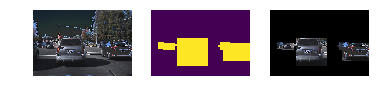

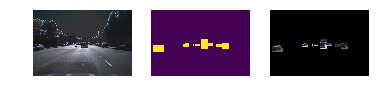

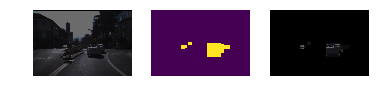

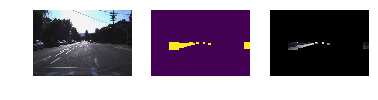

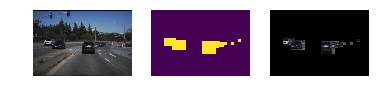

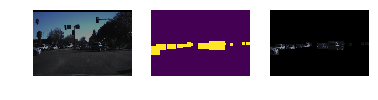

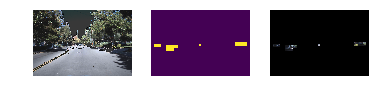

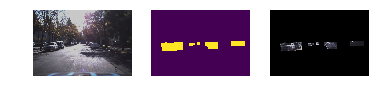

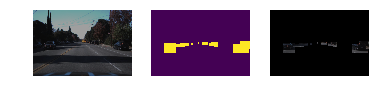

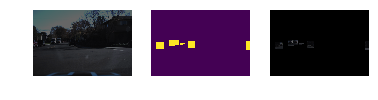

In [28]:
for i in range(10):
    im = np.array(batch_img[i],dtype=np.uint8)
    im_mask = np.array(batch_mask[i],dtype=np.uint8)
    plt.subplot(1,3,1)
    plt.imshow(im)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(im_mask[:,:,0])
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(cv2.bitwise_and(im,im,mask=im_mask));
    plt.axis('off')
    plt.show();

In [29]:
len(df_vehicles)

66389

In [30]:
### IOU or dice coeff calculation(Loss Func)
def IOU_calc(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    
    return 2*(intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def IOU_calc_loss(y_true, y_pred):
    return -IOU_calc(y_true, y_pred)

In [31]:
### Defining a small Unet
### Smaller Unet defined so it fits in memory

def get_small_unet():
    inputs = Input((img_rows, img_cols,3))
    inputs_norm = Lambda(lambda x: x/127.5 - 1.)
    conv1 = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=3)
    conv6 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=3)
    conv7 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=3)
    conv8 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=3)
    conv9 = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(up9)
    conv9 = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(conv9)

    conv10 = Convolution2D(1, 1, 1, activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)

    
    return model

In [32]:
### Generator 
training_gen = generate_train_batch(df_vehicles,1)
smooth = 1.
model = get_small_unet()
model.compile(optimizer=Adam(lr=1e-4), 
              loss=IOU_calc_loss, metrics=[IOU_calc])

In [33]:
history = model.fit_generator(training_gen,
            samples_per_epoch=10000, 
                              nb_epoch=5)

Epoch 1/5
10000/10000 [==============================] - 1166s - loss: -0.4887 - IOU_calc: 0.4887  
Epoch 2/5
10000/10000 [==============================] - 1164s - loss: -0.6211 - IOU_calc: 0.6211  
Epoch 3/5
10000/10000 [==============================] - 1164s - loss: -0.6626 - IOU_calc: 0.6626  
Epoch 4/5
10000/10000 [==============================] - 1164s - loss: -0.6834 - IOU_calc: 0.6834  
Epoch 5/5
10000/10000 [==============================] - 1167s - loss: -0.6958 - IOU_calc: 0.6958  


In [34]:
model.save('model_detect_SmallUnet.h5')

In [35]:
testing_gen = generate_test_batch(df_vehicles,20)

In [36]:
import time

start = time.time()

pred_all= model.predict(batch_img)
end = time.time()
end-start

1.3457815647125244

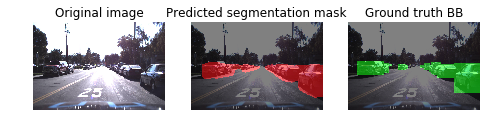

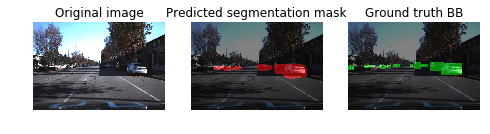

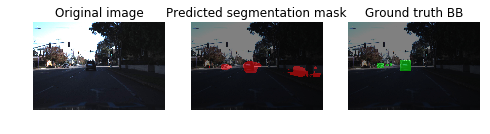

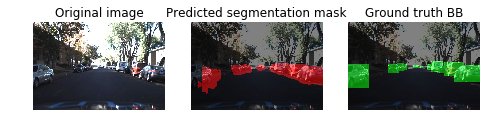

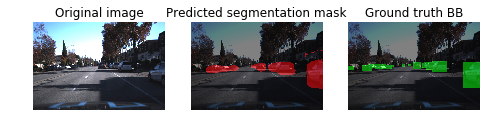

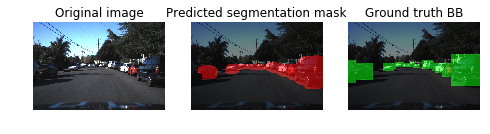

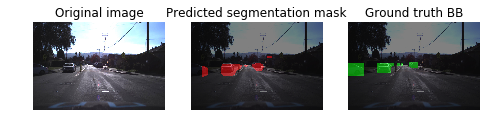

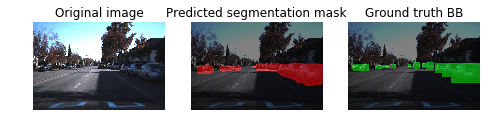

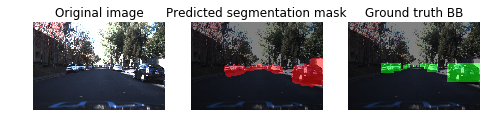

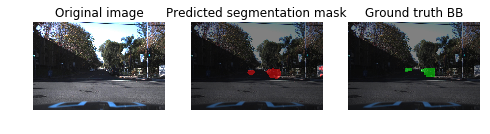

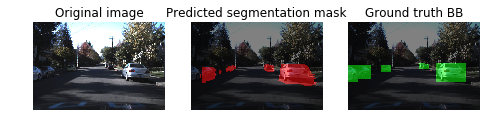

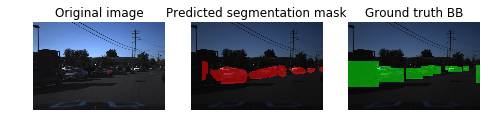

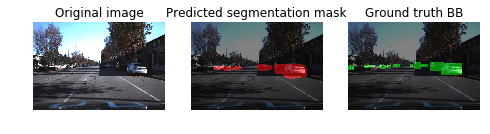

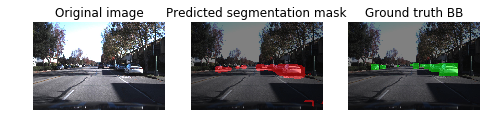

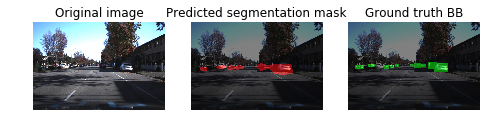

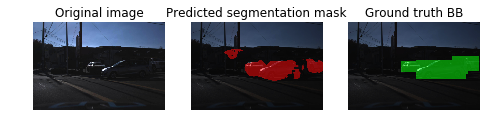

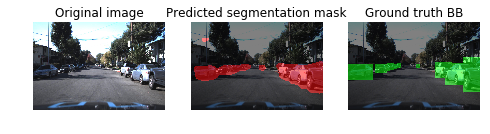

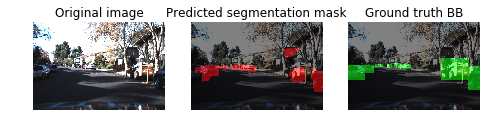

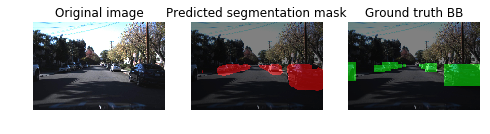

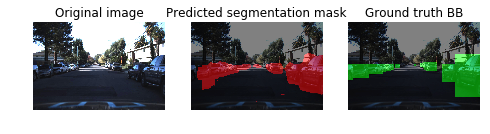

In [37]:
batch_img,batch_mask = next(testing_gen)
pred_all= model.predict(batch_img)
np.shape(pred_all)

for i in range(20):
    
    im = np.array(batch_img[i],dtype=np.uint8)
    im_mask = np.array(255*batch_mask[i],dtype=np.uint8)
    im_pred = np.array(255*pred_all[i],dtype=np.uint8)
    
    rgb_mask_pred = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
    rgb_mask_pred[:,:,1:3] = 0*rgb_mask_pred[:,:,1:2]
    rgb_mask_true= cv2.cvtColor(im_mask,cv2.COLOR_GRAY2RGB)
    rgb_mask_true[:,:,0] = 0*rgb_mask_true[:,:,0]
    rgb_mask_true[:,:,2] = 0*rgb_mask_true[:,:,2]
    
    img_pred = cv2.addWeighted(rgb_mask_pred,0.5,im,0.5,0)
    img_true = cv2.addWeighted(rgb_mask_true,0.5,im,0.5,0)
    
    plt.figure(figsize=(8,3))
    plt.subplot(1,3,1)
    plt.imshow(im)
    plt.title('Original image')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(img_pred)
    plt.title('Predicted segmentation mask')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(img_true)
    plt.title('Ground truth BB')
    plt.axis('off')
    plt.show()